In [1]:
%matplotlib inline


# Optical flow methods convergence

In this example we test the convergence of the optical flow methods available in
pySTEPS using idealized motion fields.

To test the convergence, using an example precipitation field we will:

- Read precipitation field from a file
- Morph the precipitation field using a given motion field (linear or rotor) to
  generate a sequence of moving precipitation patterns.
- Using the available optical flow methods, retrieve the motion field from the
  precipitation time sequence (synthetic precipitation observations).

Let's first load the libraries that we will use.


In [2]:
from datetime import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from scipy.ndimage import uniform_filter

import pysteps as stp
from pysteps import motion, io, rcparams
from pysteps.motion.vet import morph
from pysteps.visualization import plot_precip_field, quiver

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Load the reference precipitation data

First, we will import a radar composite from the archive.
You need the pysteps-data archive downloaded and the pystepsrc file
configured with the data_source paths pointing to data folders.



In [3]:
# Selected case
date = datetime.strptime("201505151630", "%Y%m%d%H%M")
data_source = rcparams.data_sources["mch"]

### Load the data from the archive



In [4]:
root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]

# Find the reference field in the archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep=5, num_prev_files=0
)

# Read the reference radar composite
importer = io.get_method(importer_name, "importer")
reference_field, quality, metadata = io.read_timeseries(
    fns, importer, **importer_kwargs
)

del quality  # Not used

reference_field = np.squeeze(reference_field)  # Remove time dimension

### Preprocess the data



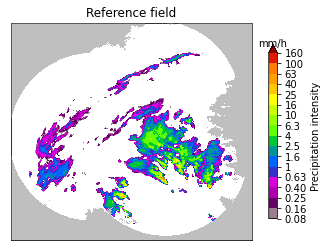

Precip. pattern shape: (640, 710)


In [5]:
# Convert to mm/h
reference_field, metadata = stp.utils.to_rainrate(reference_field, metadata)

# Mask invalid values
reference_field = np.ma.masked_invalid(reference_field)

# Plot the reference precipitation
plot_precip_field(reference_field, title="Reference field")
plt.show()

# Log-transform the data [dBR]
reference_field, metadata = stp.utils.dB_transform(
    reference_field, metadata, threshold=0.1, zerovalue=-15.0
)

print("Precip. pattern shape: " + str(reference_field.shape))

# This suppress nan conversion warnings in plot functions
reference_field.data[reference_field.mask] = np.nan

## Synthetic precipitation observations

Now we need to create a series of precipitation fields by applying the ideal
motion field to the reference precipitation field "n" times.

To evaluate the accuracy of the computed_motion vectors, we will use
a relative RMSE measure.
Relative MSE = <(expected_motion - computed_motion)^2> / <expected_motion^2>



In [6]:
# Relative RMSE = Rel_RMSE = sqrt(Relative MSE)
#
# - Rel_RMSE = 0%: no error
# - Rel_RMSE = 100%: The retrieved motion field has an average error equal in
#   magnitude to the motion field.
#
# Relative RMSE is computed over a region surrounding the precipitation
# field, were there is enough information to retrieve the motion field.
# The "precipitation region" includes the precipitation pattern plus a margin of
# approximately 20 grid points.

Let's create a function to construct different motion fields.



In [7]:
def create_motion_field(input_precip, motion_type):
    """
    Create idealized motion fields to be applied to the reference image.

    Parameters
    ----------

    input_precip: numpy array (lat, lon)

    motion_type: str
        The supported motion fields are:

            - linear_x: (u=2, v=0)
            - linear_y: (u=0, v=2)
            - rotor: rotor field

    Returns
    -------
    ideal_motion : numpy array (u, v)
    """

    # Create an imaginary grid on the image and create a motion field to be
    # applied to the image.
    ny, nx = input_precip.shape

    x_pos = np.arange(nx)
    y_pos = np.arange(ny)
    x, y = np.meshgrid(x_pos, y_pos, indexing="ij")

    ideal_motion = np.zeros((2, nx, ny))

    if motion_type == "linear_x":
        ideal_motion[0, :] = 2  # Motion along x
    elif motion_type == "linear_y":
        ideal_motion[1, :] = 2  # Motion along y
    elif motion_type == "rotor":
        x_mean = x.mean()
        y_mean = y.mean()
        norm = np.sqrt(x * x + y * y)
        mask = norm != 0
        ideal_motion[0, mask] = 2 * (y - y_mean)[mask] / norm[mask]
        ideal_motion[1, mask] = -2 * (x - x_mean)[mask] / norm[mask]
    else:
        raise ValueError("motion_type not supported.")

    # We need to swap the axes because the optical flow methods expect
    # (lat, lon) or (y,x) indexing convention.
    ideal_motion = ideal_motion.swapaxes(1, 2)
    return ideal_motion

Let's create another function that construct the temporal series of
precipitation observations.



In [8]:
def create_observations(input_precip, motion_type, num_times=9):
    """
    Create synthetic precipitation observations by displacing the input field
    using an ideal motion field.

    Parameters
    ----------

    input_precip: numpy array (lat, lon)
        Input precipitation field.

    motion_type: str
        The supported motion fields are:

            - linear_x: (u=2, v=0)
            - linear_y: (u=0, v=2)
            - rotor: rotor field

    num_times: int, optional
        Length of the observations sequence.


    Returns
    -------
    synthetic_observations: numpy array
        Sequence of observations
    """

    ideal_motion = create_motion_field(input_precip, motion_type)

    # The morph function expects (lon, lat) or (x, y) dimensions.
    # Hence, we need to swap the lat,lon axes.

    # NOTE: The motion field passed to the morph function can't have any NaNs.
    # Otherwise, it can result in a segmentation fault.
    morphed_field, mask = morph(
        input_precip.swapaxes(0, 1), ideal_motion.swapaxes(1, 2)
    )

    mask = np.array(mask, dtype=bool)

    synthetic_observations = np.ma.MaskedArray(morphed_field, mask=mask)
    synthetic_observations = synthetic_observations[np.newaxis, :]

    for t in range(1, num_times):
        morphed_field, mask = morph(
            synthetic_observations[t - 1], ideal_motion.swapaxes(1, 2)
        )
        mask = np.array(mask, dtype=bool)

        morphed_field = np.ma.MaskedArray(
            morphed_field[np.newaxis, :], mask=mask[np.newaxis, :]
        )

        synthetic_observations = np.ma.concatenate(
            [synthetic_observations, morphed_field], axis=0
        )

    # Swap  back to (lat, lon)
    synthetic_observations = synthetic_observations.swapaxes(1, 2)

    synthetic_observations = np.ma.masked_invalid(synthetic_observations)

    synthetic_observations.data[np.ma.getmaskarray(synthetic_observations)] = 0

    return ideal_motion, synthetic_observations


def plot_optflow_method_convergence(input_precip, optflow_method_name, motion_type):
    """
    Test the convergence to the actual solution of the optical flow method used.

    Parameters
    ----------

    input_precip: numpy array (lat, lon)
        Input precipitation field.

    optflow_method_name: str
        Optical flow method name

    motion_type: str
        The supported motion fields are:

            - linear_x: (u=2, v=0)
            - linear_y: (u=0, v=2)
            - rotor: rotor field
    """

    if optflow_method_name.lower() != "darts":
        num_times = 2
    else:
        num_times = 9

    ideal_motion, precip_obs = create_observations(
        input_precip, motion_type, num_times=num_times
    )

    oflow_method = motion.get_method(optflow_method_name)

    elapsed_time = time.perf_counter()

    computed_motion = oflow_method(precip_obs, verbose=False)

    print(
        f"{optflow_method_name} computation time: "
        f"{(time.perf_counter() - elapsed_time):.1f} [s]"
    )

    precip_obs, _ = stp.utils.dB_transform(precip_obs, inverse=True)

    precip_data = precip_obs.max(axis=0)
    precip_data.data[precip_data.mask] = 0

    precip_mask = (uniform_filter(precip_data, size=20) > 0.1) & ~precip_obs.mask.any(
        axis=0
    )

    cmap = get_cmap("jet").copy()
    cmap.set_under("grey", alpha=0.25)
    cmap.set_over("none")

    # Compare retrieved motion field with the ideal one
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    ax = plot_precip_field(precip_obs[0], title="Reference motion")
    quiver(ideal_motion, step=25, ax=ax)

    plt.subplot(1, 2, 2)
    ax = plot_precip_field(precip_obs[0], title="Retrieved motion")
    quiver(computed_motion, step=25, ax=ax)

    # To evaluate the accuracy of the computed_motion vectors, we will use
    # a relative RMSE measure.
    # Relative MSE = < (expected_motion - computed_motion)^2 > / <expected_motion^2 >
    # Relative RMSE = sqrt(Relative MSE)

    mse = ((ideal_motion - computed_motion)[:, precip_mask] ** 2).mean()

    rel_mse = mse / (ideal_motion[:, precip_mask] ** 2).mean()
    plt.suptitle(
        f"{optflow_method_name} " f"Relative RMSE: {np.sqrt(rel_mse) * 100:.2f}%"
    )
    plt.show()

## Lucas-Kanade

### Constant motion x-direction



LucasKanade computation time: 1.9 [s]


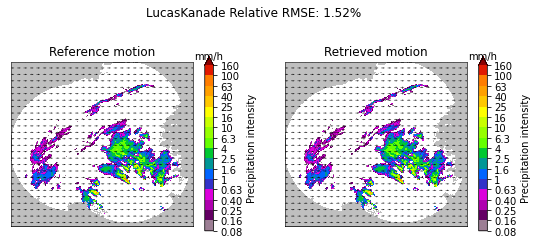

In [9]:
plot_optflow_method_convergence(reference_field, "LucasKanade", "linear_x")

### Constant motion y-direction



LucasKanade computation time: 1.9 [s]


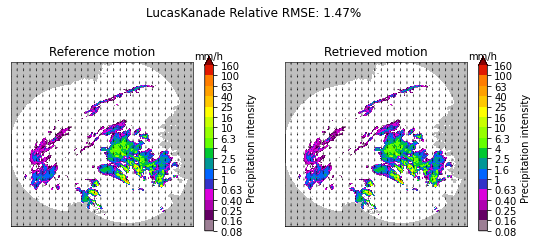

In [10]:
plot_optflow_method_convergence(reference_field, "LucasKanade", "linear_y")

### Rotational motion



LucasKanade computation time: 1.9 [s]


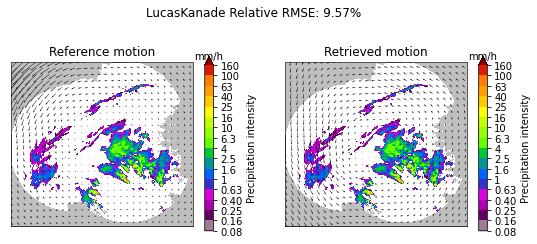

In [11]:
plot_optflow_method_convergence(reference_field, "LucasKanade", "rotor")

## Variational Echo Tracking (VET)

### Constant motion x-direction



VET computation time: 4.2 [s]


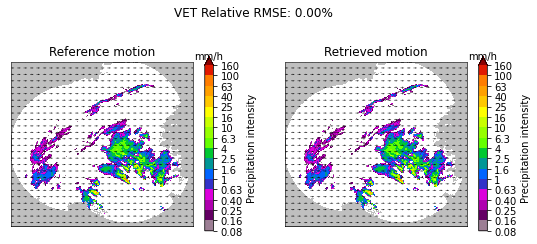

In [12]:
plot_optflow_method_convergence(reference_field, "VET", "linear_x")

### Constant motion y-direction



VET computation time: 3.9 [s]


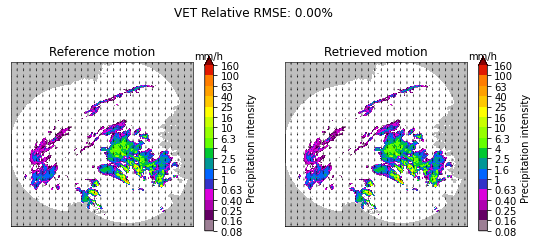

In [13]:
plot_optflow_method_convergence(reference_field, "VET", "linear_y")

### Rotational motion



VET computation time: 31.0 [s]


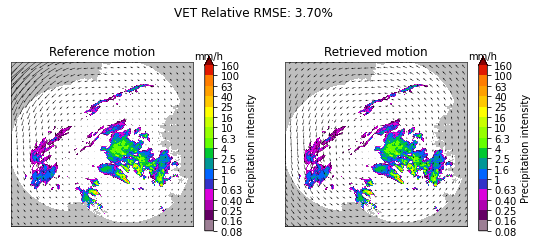

In [14]:
plot_optflow_method_convergence(reference_field, "VET", "rotor")

## DARTS

### Constant motion x-direction



DARTS computation time: 2.3 [s]


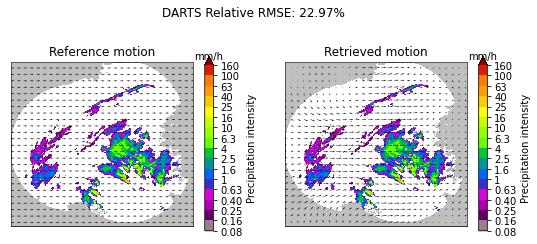

In [15]:
plot_optflow_method_convergence(reference_field, "DARTS", "linear_x")

### Constant motion y-direction



DARTS computation time: 2.3 [s]


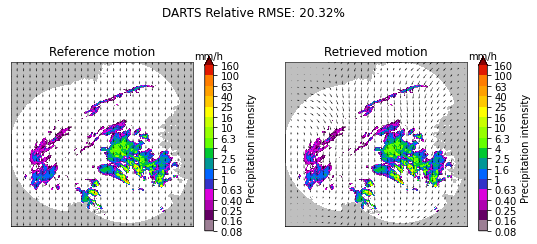

In [16]:
plot_optflow_method_convergence(reference_field, "DARTS", "linear_y")

### Rotational motion



DARTS computation time: 2.3 [s]


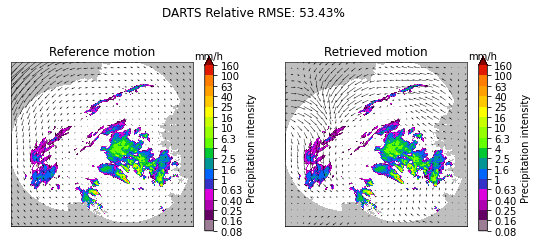

In [17]:
plot_optflow_method_convergence(reference_field, "DARTS", "rotor")

# sphinx_gallery_thumbnail_number = 5